In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
import networkx as nx
from scipy.optimize import minimize, Bounds
from itertools import chain, combinations
from b_spline_fitting import x_fit_bspline, fit_bspline_protein_expression
import os

In [2]:
def _powerSet(iterable, second_order=True):
    """Computes the powerset of a given iterable of numbers. Filters out any set bigger than size 3 as the paper restricts
    genes to be regulated by at max 2 proteins to reduce the complexity of the model.

    Example: [1, 2, 3] --> [(), (1,), (2,), (3,), (1, 2), (1, 3), (2, 3)]

    Args:
        iterable (int[]): list of genes

    Returns:
        tuple[]: list of possible gene combinations that can regulate a gene
    """
    s = list(iterable)
    powerset = list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))
    if second_order:
        shrinked_powerset = [item for item in powerset if len(item) < 3]
    else:
        shrinked_powerset = [item for item in powerset if len(item) < 2]

    return shrinked_powerset

In [3]:
def _interval_detection(t, intervals):
    """Finds time interval, described by its upperbound, to which t belongs.
    Args:
        t (float): time point
        T (float[]): list of time point intervals

    Returns:
        float: time point interval to which t belongs
    """
    idx = intervals[intervals > t]
    if len(idx) == 0:
        return intervals[len(intervals)-1]
    return idx[0]

In [4]:
haemato_endothelial_progenitors = np.load("../data/embyo_rna/atlas/normalized_gene_expr_data/haematoendothelial_progenitors_normalized.npy")
visceral_endoderm = np.load("../data/embyo_rna/atlas/normalized_gene_expr_data/visceral_endoderm_normalized.npy")
genes = ["Nanog", "Pou5f1", "Sox2", "Tbx3", "Klf2", "Nodal"] # Oct4 = Pou5f1
marker = ['s', 'D', 'h', 'o', '*', '8']
stages = ["E" + str(i) for i in np.arange(6.5, 8.51, 0.25)]


In [5]:
### PARAMETERS ###
lmbda = 1
k = 4
number_of_genes = len(genes)
knots = np.linspace(0, len(stages), num=15)
D = len(knots) - k - 1
R = 10 # number of intervals
detection_threshold = 0.1
assert R >= D, "R is not bigger or equal to D"

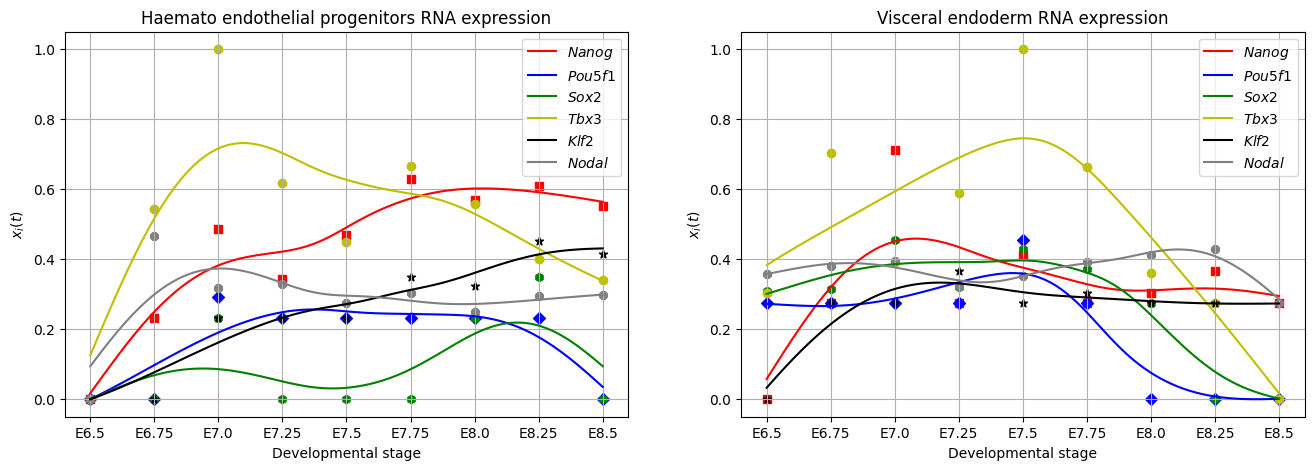

In [6]:
### FITTING DATA - data set 1  smooth - different initial values ###
artificial_t = np.arange(len(stages))
printing_t = np.linspace(0, len(stages)-1, num=100)

x_fit_haemato_endothelial_progenitors = x_fit_bspline(artificial_t, haemato_endothelial_progenitors.T, knots, lmbda, k) # solving minimization problem described by P1
x_fit_visceral_endoderm = x_fit_bspline(artificial_t, visceral_endoderm.T, knots, lmbda, k) # solving minimization problem described by P1

colors = ['r', 'b', 'g', 'y', 'black', 'grey']

fig, axs = plt.subplots(1, 2, figsize=(16,5), sharey=False)

for i, gene in enumerate(genes):
    axs[0].plot(printing_t, x_fit_haemato_endothelial_progenitors[i](printing_t), color=colors[i], label=f"${gene}$")
    axs[0].scatter(stages, haemato_endothelial_progenitors[i], color=colors[i],  marker=marker[i])

for i, gene in enumerate(genes):
    axs[1].plot(printing_t, x_fit_visceral_endoderm[i](printing_t), color=colors[i], label=f"${gene}$")
    axs[1].scatter(stages, visceral_endoderm[i], color=colors[i],  marker=marker[i])

axs[1].legend()
axs[1].set_xlabel('Developmental stage')
axs[1].set_ylabel(r"$x_i(t)$")
axs[1].set_title("Visceral endoderm RNA expression")
axs[1].grid()

axs[0].legend()
axs[0].set_xlabel('Developmental stage')
axs[0].set_ylabel(r"$x_i(t)$")
axs[0].set_title("Haemato endothelial progenitors RNA expression")
axs[0].grid()
fig.show()


In [7]:
### FITTING PROTEIN EXPRESSION DATA PARAMETERS ###
protein_degradation_rate = np.array([0.5 for _ in range(number_of_genes)]) 
protein_translation_rate = np.array([1 for _ in range(number_of_genes)]) # taken from experiment 4.1

Text(0.5, 1.0, 'Visceral endoderm protein expression')

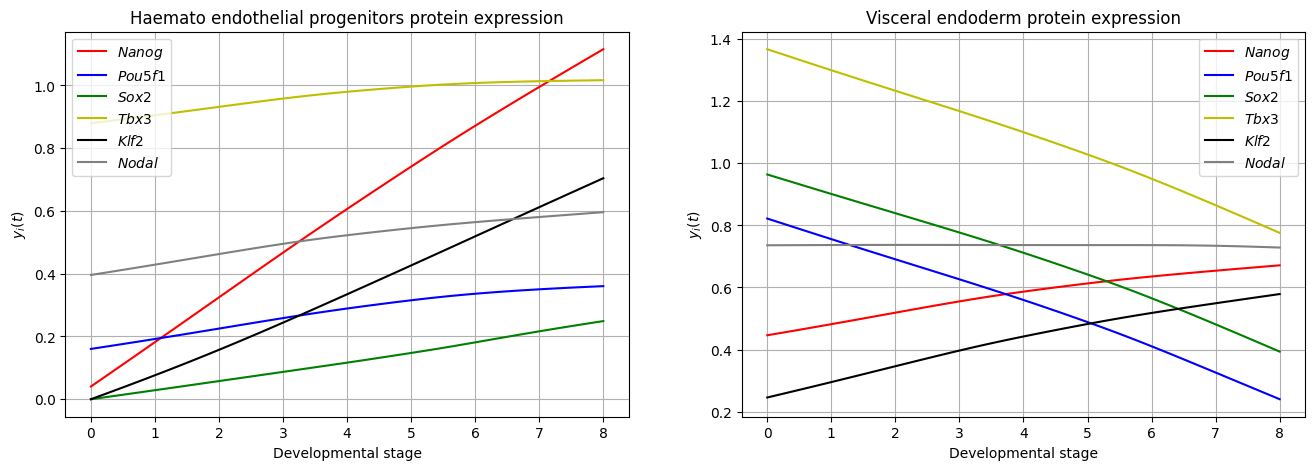

In [8]:
### FITTING PROTEIN EXPRESSION ###

alpha_haemato_endothelial_progenitors = np.zeros((number_of_genes, D)) # weights for the B-spline basis functions to create the B-spline curve
alpha_visceral_endoderm = np.zeros((number_of_genes, D))

for g in range(number_of_genes):
    x_i_h = x_fit_haemato_endothelial_progenitors[g](artificial_t)
    alpha_haemato_endothelial_progenitors[g, :] = fit_bspline_protein_expression(protein_translation_rate[g], protein_degradation_rate[g], artificial_t, knots, k, D, x_i_h)
    x_i_v = x_fit_visceral_endoderm[g](artificial_t)
    alpha_visceral_endoderm[g, :] = fit_bspline_protein_expression(protein_translation_rate[g], protein_degradation_rate[g], artificial_t, knots, k, D, x_i_v)
    
fig, axs = plt.subplots(1, 2, figsize = (16, 5), sharey=False)

for i, gene in enumerate(genes):
    axs[0].plot(printing_t, BSpline(knots, alpha_haemato_endothelial_progenitors[i], k)(printing_t), color=colors[i], label=f"${gene}$")

axs[0].grid()
axs[0].legend()
axs[0].set_xlabel('Developmental stage')
axs[0].set_ylabel(r"$y_i(t)$")
axs[0].set_title("Haemato endothelial progenitors protein expression")

for i, gene in enumerate(genes):
    axs[1].plot(printing_t, BSpline(knots, alpha_visceral_endoderm[i], k)(printing_t), color=colors[i], label=f"${gene}$")

axs[1].grid()
axs[1].legend()
axs[1].set_xlabel('Developmental stage')
axs[1].set_ylabel(r"$y_i(t)$")
axs[1].set_title("Visceral endoderm protein expression")

# fig.show()


In [9]:
t_intervals = np.linspace(0, len(stages), R + 1) # create interval boundaries 
t_interval_size = t_intervals[1]

# G_t definition as in the paper 
G_t = {i: set() for i in t_intervals[1::]} # The set of all indices that correspond to protein encoding genes that were detected having changed gene expression significantly. Start with interval [0,x) which is indicated as key x. Then interval [x, 2*x) etc.
not_detected = [i for i in range(number_of_genes)] # list of non detected genes

# detection of out-of-steady-state genes, creating G_t (and M_t) as described in section 3.2
for j, tt in enumerate(t_intervals[0:len(t_intervals)-1]):
    to_be_removed = []
    for gene_i in not_detected:
        t_interval_time_points = np.linspace(tt, tt+t_interval_size, 1000)
        min_interval = min(x_fit_haemato_endothelial_progenitors[gene_i](t_interval_time_points))
        max_interval = max(x_fit_haemato_endothelial_progenitors[gene_i](t_interval_time_points))
        if (abs(min_interval - x_fit_haemato_endothelial_progenitors[gene_i](0)) > detection_threshold) or (abs(max_interval - x_fit_haemato_endothelial_progenitors[gene_i](0)) > detection_threshold):
            to_be_removed.append(gene_i)
            for ttt in t_intervals[j+1:len(t_intervals)]:
                G_t[ttt].add(gene_i)
            
    for gene_j in to_be_removed:
        not_detected.remove(gene_j)

print(G_t)

{0.9: {0, 3, 5}, 1.8: {0, 1, 3, 4, 5}, 2.7: {0, 1, 3, 4, 5}, 3.6: {0, 1, 3, 4, 5}, 4.5: {0, 1, 3, 4, 5}, 5.4: {0, 1, 2, 3, 4, 5}, 6.3: {0, 1, 2, 3, 4, 5}, 7.2: {0, 1, 2, 3, 4, 5}, 8.1: {0, 1, 2, 3, 4, 5}, 9.0: {0, 1, 2, 3, 4, 5}}


In [10]:
all_possible_regulators = _powerSet(list(G_t.values())[-1], second_order=True)
regulator_idx = {}
for idx, regs in enumerate(all_possible_regulators):
    regulator_idx[regs] = idx # make sure indexing for a (pair of) regulator(s) is consistent for different sizes of G(t)
    
print(all_possible_regulators)
N_t_L = len(all_possible_regulators) # largest set of regulators (out of steady-state genes) found. I.e. N(t_L) in the paper. 
p_vector = np.ones((number_of_genes, len(artificial_t), 2*N_t_L)) # matrix holding p vector as described in equation 11 
for g in range(number_of_genes): 
    for t_idx, tt in enumerate(artificial_t): 
        interval = _interval_detection(tt, np.array(list(G_t.keys()))) 
        protein_regulators_possibilities = _powerSet(G_t[interval], second_order=True)
        for regulators in protein_regulators_possibilities: 
            y_k = 1 
            for regulator in regulators:
                y_k *=  BSpline(knots, alpha_haemato_endothelial_progenitors[regulator], k=k)(tt) 
            if y_k < 0 and y_k < 1e-6: # due to imperfect fitting, the 
                print(f"t = {tt}, regulators = {regulators}") 
                print(y_k)
                y_k = 0
            p_vector[g, t_idx, regulator_idx[regulators]] = y_k 

[(), (0,), (1,), (2,), (3,), (4,), (5,), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]


In [11]:
def objective(x, P, gamma1, gamma2):
    n = len(x) // 2
    b = x[n:]
    # return np.linalg.norm(P.dot(x), ord=2)**2 + gamma1*np.linalg.norm(b, ord=1) + gamma2 * np.linalg.norm(b, ord=2)
    return np.sum(P.dot(x)**2) + (gamma1/2)*np.linalg.norm(b, ord=1) + gamma2 * np.linalg.norm(b, ord=2)

def constraint1(x):
    n = len(x) // 2
    return x[n] - 1  # Constraint: The first entry in b should be 1

def constraint2(x):
    n = len(x) // 2
    a = x[:n]
    b = x[n:]
    return b - a # Constraint: a <= b

def constraint3(x):
    n = len(x) // 2
    a = x[:n]
    return a # Constraint: 0 <= a

def constraint4(x):
    n = len(x) // 2
    a = x[:n]
    b = x[n:]
    return (np.sum(a))/(np.sum(b)) # constraint that f(Y) >= 0

def constraint5(x):
    n = len(x) // 2
    a = x[:n]
    b = x[n:]
    return -(np.sum(a)/np.sum(b)) + 1 # constraint that 1 >= f(Y)

def P3(P, gamma1, gamma2):
    n = len(P[0]) // 2 # number of regulators

    bounds = Bounds(lb=[0]*2*n, ub=[np.inf]*2*n)

    constraints = [
        {'type': 'eq', 'fun': constraint1},
        {'type': 'ineq', 'fun': constraint2},
        {'type': 'ineq', 'fun': constraint3},
        {'type': 'ineq', 'fun': constraint4},
        {'type': 'ineq', 'fun': constraint5}
    ]

    w0 = np.zeros(2*n)
    np.random.seed(2)
    lower_bound = np.random.uniform(0, 100, n) 
    upper_bound = np.random.uniform(lower_bound, 100, n)
    w0[:n] = lower_bound
    w0[n:] = upper_bound
    
    result = minimize(objective, w0, bounds=bounds, constraints=constraints, args=(P, gamma1, gamma2), method="SLSQP")

    return result.x, result.fun    

In [12]:
lmbda_RNA = [1 for i in range(number_of_genes)] # taken from the paper
for g in range(number_of_genes):
    for t_idx, tt in enumerate(artificial_t):
        c_t = lmbda_RNA[g] * x_fit_haemato_endothelial_progenitors[g](tt) + x_fit_haemato_endothelial_progenitors[g].derivative()(tt)   
        p_vector[g, t_idx, N_t_L:] = p_vector[g, t_idx, :N_t_L] * -c_t 
        p_vector[g, t_idx, N_t_L:] = np.where(p_vector[g, t_idx, N_t_L:] == -0.0, 0.0, p_vector[g, t_idx, N_t_L:]) # does this matter?

gamma2 = np.logspace(-5,5,10)
gamma1 = np.logspace(-5,5,10)
omega = [np.inf for i in range(number_of_genes)]
coef = np.zeros((number_of_genes, 2*N_t_L))

for g1 in gamma1:
    for g2 in gamma2:
        for i in range(number_of_genes):
            c, omega_value = P3(p_vector[i], g1, g2) # c outputs the a and b vector concatenated.

            if omega_value < omega[i]:
                omega[i] = omega_value
                coef[i] = c

print(f"Function value: {np.sum(omega)}")
coef = np.where(np.abs(coef) < 1e-6, 0, coef)
for i in range(number_of_genes):
    print(coef[i].round(3))


Function value: 0.49021110885368796
[0.529 0.    0.    0.    0.    0.    0.    0.    0.    0.35  0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.
 0.    0.    0.    0.    0.    0.    0.    0.35  0.    0.    0.    0.
 0.751 0.    0.    0.168 0.    0.    0.    0.   ]
[0.106 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.123 0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.123 0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.096 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.904 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.194 0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.
 0.    0.    0.    0.    0.    0.    0.    0

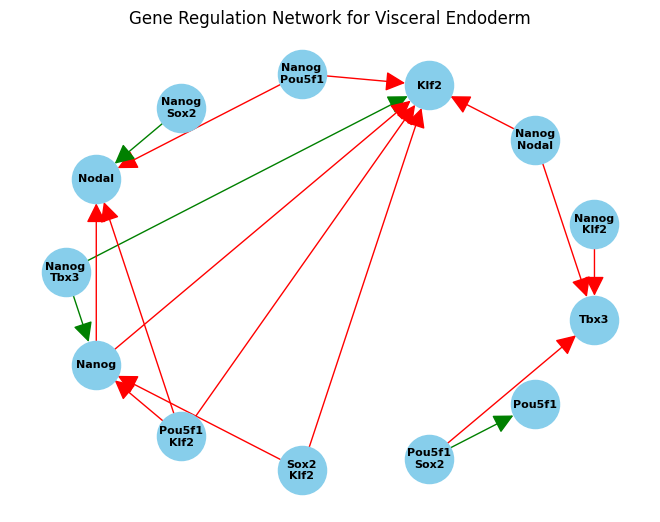

In [13]:
# Create a directed graph
graph = nx.DiGraph()

# Create nodes
for i in range(number_of_genes):
    coef_per_gene = coef[i]
    non_zero_indices = np.where(coef_per_gene > 1e-6)[0]
    
    for j in non_zero_indices:
        if j < N_t_L and j > 0:
            # Genes upregulating gene i
            regulator_node = all_possible_regulators[j]
            if len(regulator_node) == 1:
                regulator_node = [regulator_node[0]]
            
            regulator_node = [genes[i] for i in regulator_node]
            regulator_node = "\n".join(regulator_node)
            if regulator_node not in graph:
                graph.add_node(regulator_node)

            graph.add_edge(regulator_node, genes[i], color='g', weight=coef_per_gene[j])
        
        elif j >= N_t_L:
            # Genes downregulating gene i
            j -= N_t_L

            if j > 0:
                regulator_node = all_possible_regulators[j]
                regulator_node = [genes[i] for i in regulator_node]
                regulator_node = "\n".join(regulator_node)

                if regulator_node not in graph:
                    graph.add_node(regulator_node)

                if coef_per_gene[j + N_t_L] > coef_per_gene[j]:
                    w = 0
                    if coef_per_gene[j] == 0:
                        w = coef_per_gene[j + N_t_L]
                    else:
                        w = coef_per_gene[j + N_t_L] / coef_per_gene[j]
                    graph.add_edge(regulator_node, genes[i], color='r', weight=w)

# Draw the graph with edge colors
pos = nx.shell_layout(graph)

edge_colors = [graph[u][v]['color'] for u, v in graph.edges]
# weights = [graph[u][v]['weight'] for u, v in graph.edges]
# weights = (max(weights) - weights)/(max(weights) - min(weights))

# Draw the graph with edge colors and weights
nx.draw(graph, pos, with_labels=True, node_size=1200, font_size=8, font_color="black", font_weight="bold",
        node_color="skyblue", edge_color=edge_colors, arrowsize=30)

plt.title("Gene Regulation Network for haemato Endothelial Progenitors")
plt.show()


In [14]:
# G_t definition as in the paper 
G_t = {i: set() for i in t_intervals[1::]} # The set of all indices that correspond to protein encoding genes that were detected having changed gene expression significantly. Start with interval [0,x) which is indicated as key x. Then interval [x, 2*x) etc.
not_detected = [i for i in range(number_of_genes)] # list of non detected genes

# detection of out-of-steady-state genes, creating G_t (and M_t) as described in section 3.2
for j, tt in enumerate(t_intervals[0:len(t_intervals)-1]):
    to_be_removed = []
    for gene_i in not_detected:
        t_interval_time_points = np.linspace(tt, tt+t_interval_size, 1000)
        min_interval = min(x_fit_visceral_endoderm[gene_i](t_interval_time_points))
        max_interval = max(x_fit_visceral_endoderm[gene_i](t_interval_time_points))
        if (abs(min_interval - x_fit_visceral_endoderm[gene_i](0)) > detection_threshold) or (abs(max_interval - x_fit_visceral_endoderm[gene_i](0)) > detection_threshold):
            to_be_removed.append(gene_i)
            for ttt in t_intervals[j+1:len(t_intervals)]:
                G_t[ttt].add(gene_i)
            
    for gene_j in to_be_removed:
        not_detected.remove(gene_j)

print(G_t)

{0.9: {0, 4}, 1.8: {0, 3, 4}, 2.7: {0, 3, 4}, 3.6: {0, 3, 4}, 4.5: {0, 3, 4}, 5.4: {0, 1, 3, 4}, 6.3: {0, 1, 2, 3, 4}, 7.2: {0, 1, 2, 3, 4}, 8.1: {0, 1, 2, 3, 4}, 9.0: {0, 1, 2, 3, 4, 5}}


In [15]:
all_possible_regulators = _powerSet(list(G_t.values())[-1], second_order=True)
regulator_idx = {}
for idx, regs in enumerate(all_possible_regulators):
    regulator_idx[regs] = idx # make sure indexing for a (pair of) regulator(s) is consistent for different sizes of G(t)
    
print(all_possible_regulators)
N_t_L = len(all_possible_regulators) # largest set of regulators (out of steady-state genes) found. I.e. N(t_L) in the paper. 
p_vector = np.ones((number_of_genes, len(artificial_t), 2*N_t_L)) # matrix holding p vector as described in equation 11 
for g in range(number_of_genes): 
    for t_idx, tt in enumerate(artificial_t): 
        interval = _interval_detection(tt, np.array(list(G_t.keys()))) 
        protein_regulators_possibilities = _powerSet(G_t[interval], second_order=True)
        for regulators in protein_regulators_possibilities: 
            y_k = 1 
            for regulator in regulators:
                y_k *=  BSpline(knots, alpha_visceral_endoderm[regulator], k=k)(tt) 
            if y_k < 0 and y_k < 1e-6: # due to imperfect fitting, the 
                print(f"t = {tt}, regulators = {regulators}") 
                print(y_k)
                y_k = 0
            p_vector[g, t_idx, regulator_idx[regulators]] = y_k 

[(), (0,), (1,), (2,), (3,), (4,), (5,), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]


In [16]:
lmbda_RNA = [1 for i in range(number_of_genes)] # taken from the paper
for g in range(number_of_genes):
    for t_idx, tt in enumerate(artificial_t):
        c_t = lmbda_RNA[g] * x_fit_visceral_endoderm[g](tt) + x_fit_visceral_endoderm[g].derivative()(tt)   
        p_vector[g, t_idx, N_t_L:] = p_vector[g, t_idx, :N_t_L] * -c_t 
        p_vector[g, t_idx, N_t_L:] = np.where(p_vector[g, t_idx, N_t_L:] == -0.0, 0.0, p_vector[g, t_idx, N_t_L:]) # does this matter?

gamma2 = np.logspace(-5,5,10)
gamma1 = np.logspace(-5,5,10)
omega = [np.inf for i in range(number_of_genes)]
coef = np.zeros((number_of_genes, 2*N_t_L))

for g1 in gamma1:
    for g2 in gamma2:
        for i in range(number_of_genes):
            c, omega_value = P3(p_vector[i], g1, g2) # c outputs the a and b vector concatenated.

            if omega_value < omega[i]:
                omega[i] = omega_value
                coef[i] = c

print(f"Function value: {np.sum(omega)}")
coef = np.where(np.abs(coef) < 1e-6, 0, coef)
for i in range(number_of_genes):
    print(coef[i].round(3))


Function value: 0.8998161574593556
[0.291 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.181 0.    0.    0.    0.    0.    0.    0.    1.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.181 0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.426 0.    0.    0.    0.    0.    0.    0.    1.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.426 0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.402 0.    0.199 0.    0.    0.    0.    0.    0.    0.    1.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.402 0.
 0.199 0.    0.    0.    0.    0.    0.    0.   ]
[0.018 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.952 0.    0.513 0.    0.    0.    0.    0.    0.    0.    1.    0.
 0.    0.    0.    0.    0.    0.    0.    0.

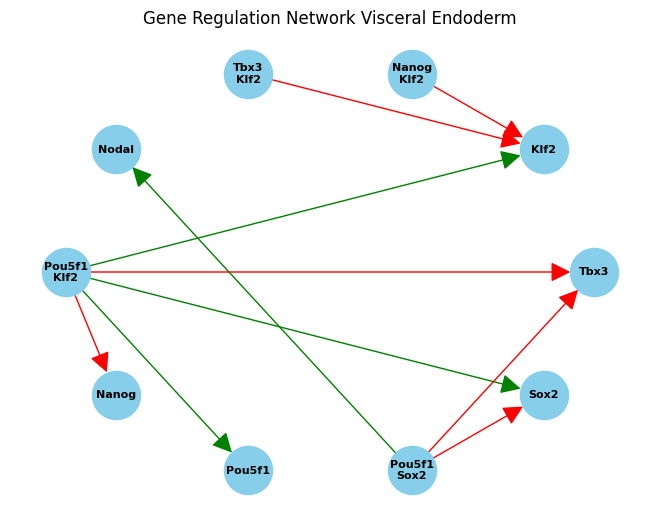

In [18]:
# Create a directed graph
graph = nx.DiGraph()

# Create nodes
for i in range(number_of_genes):
    coef_per_gene = coef[i]
    non_zero_indices = np.where(coef_per_gene > 1e-6)[0]
    
    for j in non_zero_indices:
        if j < N_t_L and j > 0:
            # Genes upregulating gene i
            regulator_node = all_possible_regulators[j]
            if len(regulator_node) == 1:
                regulator_node = [regulator_node[0]]
            
            regulator_node = [genes[i] for i in regulator_node]
            regulator_node = "\n".join(regulator_node)
            if regulator_node not in graph:
                graph.add_node(regulator_node)

            graph.add_edge(regulator_node, genes[i], color='g', weight=coef_per_gene[j])
        
        elif j >= N_t_L:
            # Genes downregulating gene i
            j -= N_t_L

            if j > 0:
                regulator_node = all_possible_regulators[j]
                regulator_node = [genes[i] for i in regulator_node]
                regulator_node = "\n".join(regulator_node)

                if regulator_node not in graph:
                    graph.add_node(regulator_node)

                if coef_per_gene[j + N_t_L] > coef_per_gene[j]:
                    w = 0
                    if coef_per_gene[j] == 0:
                        w = coef_per_gene[j + N_t_L]
                    else:
                        w = coef_per_gene[j + N_t_L] / coef_per_gene[j]
                    graph.add_edge(regulator_node, genes[i], color='r', weight=w)

# Draw the graph with edge colors
pos = nx.shell_layout(graph)

edge_colors = [graph[u][v]['color'] for u, v in graph.edges]
# weights = [graph[u][v]['weight'] for u, v in graph.edges]
# weights = (max(weights) - weights)/(max(weights) - min(weights))

# Draw the graph with edge colors and weights
nx.draw(graph, pos, with_labels=True, node_size=1200, font_size=8, font_color="black", font_weight="bold",
        node_color="skyblue", edge_color=edge_colors, arrowsize=30)

plt.title("Gene Regulation Network Visceral Endoderm")
plt.show()
